# Grzegorz Krochmal and Katarzyna Kryńska
## *Prediction of LendingClub loan defaulters*

# Introduction

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Data Overview

In [85]:
data = pd.read_csv("D:\WNE\lending-club-loan-data\loan.csv", low_memory=False)

In [86]:
data.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
col_desc = pd.read_excel("LCDataDictionary.xlsx", sheet_name="LoanStats")
col_desc.head(5)

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


In [88]:
data.loan_status.describe()

count        2260668
unique             9
top       Fully Paid
freq         1041952
Name: loan_status, dtype: object

In [89]:
data.loan_status.value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

We are interested in loans that already finished (there are no more payments to be expected), so we will leave only rows in which the loan status is *Fully Paid* or *Default*. We will also concatenate *Charged Off* and *Default* as we believe clients who have the loan status *Charged Off* are just as big credit risk as those with default. 

In [90]:
data['loan_status'] = data['loan_status'].replace({'Charged Off':'Default'})
data = data[np.any([data.loan_status == 'Default', data.loan_status == 'Fully Paid'], axis=0)]

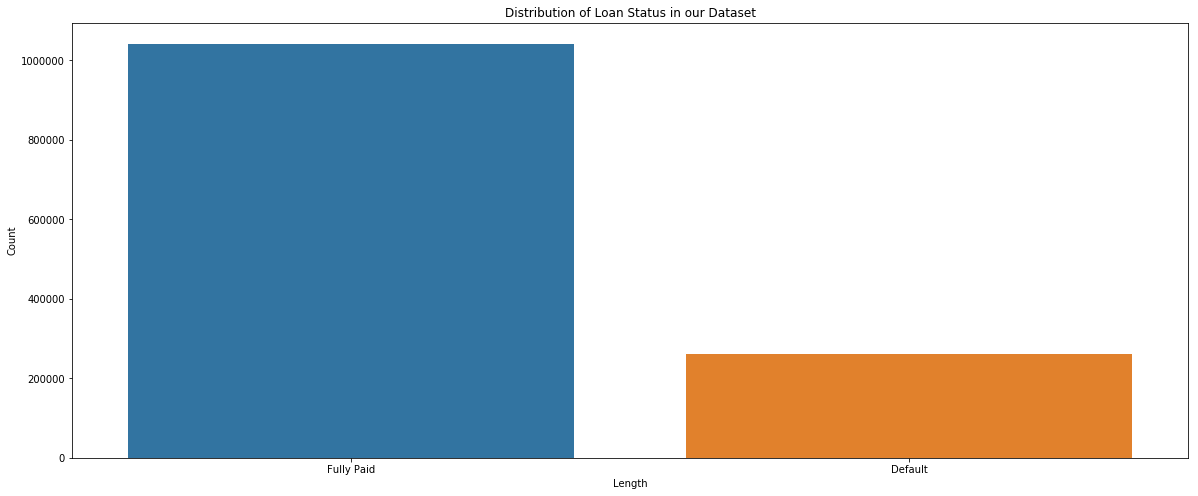

In [91]:
m = data['loan_status'].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ['Loan Status','Count']
plt.subplots(figsize=(20,8))
sns.barplot(y='Count', x='Loan Status', data=m)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Loan Status in our Dataset")
plt.show()

%% Our data is imbalanced

# 2. Data preparation

## 2.1. Data cleaning

In [92]:
missings = pd.DataFrame({'Count': data.isnull().sum(), 'Percent': 100*data.isnull().sum()/len(data)})
missings['LoanStatNew'] = list(missings.index)
missings = missings.join(col_desc.set_index('LoanStatNew'), on='LoanStatNew')
missings = missings.drop(columns='LoanStatNew')

In [93]:
missings[missings['Percent'] > 10].sort_values(by=['Percent'], ascending=False) 

,Count,Percent,Description
id,1303638,100.000000,A unique LC assigned ID for the loan listing.
url,1303638,100.000000,URL for the LC page with listing data.
member_id,1303638,100.000000,A unique LC assigned Id for the borrower member.
next_pymnt_d,1303607,99.997622,Next scheduled payment date
orig_projected_additional_accrued_interest,1300205,99.736660,The original projected additional interest amo...
hardship_last_payment_amount,1298303,99.590761,The last payment amount as of the hardship pla...
hardship_start_date,1298303,99.590761,The start date of the hardship plan period
hardship_type,1298303,99.590761,Describes the hardship plan offering
hardship_reason,1298303,99.590761,Describes the reason the hardship plan was off...
hardship_payoff_balance_amount,1298303,99.590761,The payoff balance amount as of the hardship p...


In [94]:
data.hardship_status = data.hardship_status.fillna("NO_HARDSHIP")
data.hardship_reason = data.hardship_reason.fillna("NO_HARDSHIP")

In [78]:
pd.crosstab(data.hardship_status, data.loan_status)

loan_status,Default,Fully Paid
hardship_status,,
ACTIVE,1,0
BROKEN,1813,89
COMPLETED,2003,1429
NO_HARDSHIP,257869,1040434


In [80]:
pd.crosstab(data.hardship_reason, data.loan_status)

loan_status,Default,Fully Paid
hardship_reason,,
DISABILITY,69,19
DIVORCE,106,27
EXCESSIVE_OBLIGATIONS,758,229
FAMILY_DEATH,65,27
INCOME_CURTAILMENT,513,121
MEDICAL,474,132
NATURAL_DISASTER,739,767
NO_HARDSHIP,257869,1040434
REDUCED_HOURS,254,56


In [81]:
data1 = data.dropna(axis=1, thresh=int(0.50*len(data)))

In [82]:
data1.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,hardship_reason,hardship_status,disbursement_method,debt_settlement_flag
100,30000,30000,30000.0,36 months,22.35,1151.16,D,D5,Supervisor,5 years,...,0.0,527120.0,98453.0,28600.0,101984.0,N,NO_HARDSHIP,NO_HARDSHIP,Cash,N
152,40000,40000,40000.0,60 months,16.14,975.71,C,C4,Assistant to the Treasurer (Payroll),< 1 year,...,0.0,344802.0,161720.0,45700.0,167965.0,N,NO_HARDSHIP,NO_HARDSHIP,Cash,N
170,20000,20000,20000.0,36 months,7.56,622.68,A,A3,Teacher,10+ years,...,0.0,622183.0,71569.0,85100.0,74833.0,N,NO_HARDSHIP,NO_HARDSHIP,Cash,N
186,4500,4500,4500.0,36 months,11.31,147.99,B,B3,Accounts Examiner III,10+ years,...,0.0,53795.0,29137.0,15100.0,24595.0,N,NO_HARDSHIP,NO_HARDSHIP,Cash,N
215,8425,8425,8425.0,36 months,27.27,345.18,E,E5,Senior Director Risk Management,3 years,...,0.0,768304.0,189194.0,45800.0,189054.0,N,NO_HARDSHIP,NO_HARDSHIP,Cash,N
